In [1]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import plotly.graph_objects as go

#import local module for analysis
from WRFChemToolkit.analysis import functions as anly
from WRFChemToolkit.plots import functions as plot

# PM25 time series analysis

In [20]:
datapath ='/geos/d21/s1878599/BB_season2017_16cores_holmes/wrfout_d01_2017-10-11_00:00:00'
#Merge datasets
ds = xr.open_dataset(datapath)

In [3]:
def pm25_component_of(dataset, species):
    """
    Sum up the species values for bin sizes (from 1 to 3) making up PM25.
    Add the total contribution of the species to PM25 concentration.
    TODO change units from mixing ratio to ug/m3.

    :param species: name of the chemical species
    :type species: string.
    :return:
    :rtype: xarray DataArray.
    """
    return dataset[species + '_a01'] + dataset[species + '_a02'] + dataset[
        species + '_a03']

In [4]:
def var_space_mean(ds):
 """
  Make the average over '' dimension of a datarray.

  :param da:
    datarray to be averaged.
  :type da: xarray DataArray.
  :return:
    Time averaged da.
  :rtype: xarray DataSet.
 """
 return xr.Dataset(dict(ds.mean(dim= ['south_north','west_east'],
                                   keep_attrs=True).data_vars), coords=dict(ds.coords))

## Inorganic PM25 components

In [21]:
#sum up components
ds['so4_pm25'] = pm25_component_of(ds,'so4')
ds['nh4_pm25'] = pm25_component_of(ds,'nh4')
ds['no3_pm25'] = pm25_component_of(ds,'no3')

In [6]:
#Space_avg
avg =var_space_mean(ds)

In [7]:
#create dates.
dates = pd.DatetimeIndex(ds.XTIME.values)

In [8]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y= avg.so4_pm25[:,0].values,
                    mode='lines',
                    name='sulfate so4'))

fig.add_trace(go.Scatter(x=dates, y= avg.nh4_pm25[:,0].values,
                    mode='lines',
                    name='ammonium nh4'))

fig.add_trace(go.Scatter(x=dates, y= avg.no3_pm25[:,0].values,
                    mode='lines',
                    name='nitrate no3'))

# Edit the layout
fig.update_layout(title='SIA PM2.5 - Inorganic components of PM2.5 ug/kg-dryair',
                   xaxis_title='Date',
                   yaxis_title='mixing ratio')

NOTE: weird behaviour at 29/10. date is set back to 08/10 for few hours then recovers. 
      During this 'shut down' all variables have zero values. 29 has been removed.

## BC and OC PM25 components

In [22]:
#Black carbon organic carbon BC OC
#sum up components
ds['oc_pm25'] = pm25_component_of(ds,'oc')
ds['bc_pm25'] = pm25_component_of(ds,'bc')

In [10]:
#Space_avg
avg2 =var_space_mean(ds)

In [11]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y= avg2.oc_pm25[:,0].values,
                    mode='lines',
                    name='organic carbon'))

fig.add_trace(go.Scatter(x=dates, y= avg2.bc_pm25[:,0].values,
                    mode='lines',
                    name='black carbon'))

# Edit the layout
fig.update_layout(title='BC and OC of PM2.5 ug/kg-dryair',
                   xaxis_title='date',
                   yaxis_title='mixing ratio')

## PM2.5 OA (SOA+POA)

In [23]:
#PM2.5 Secondary Organic Aerosols components (SOA)
ds['pm25_bio_soa'] = pm25_component_of(ds,'biog1_o') + pm25_component_of(ds,'biog1_c')  # biogenic from isoprene and pinenes
ds['pm25_bb_soa']  =  pm25_component_of(ds,'smpbb') #biomass burning
ds['pm25_anthro_soa'] = pm25_component_of(ds,'smpa')  #anthropogenic
ds['pm25_gly_soa'] = pm25_component_of(ds,'glysoa_sfc') #glyoxal

ds['pm25_soa'] = (ds['pm25_bio_soa'] + ds['pm25_bb_soa'] + ds['pm25_anthro_soa']+ ds['pm25_gly_soa']) #total PM2.5 SOA ug/m3

In [13]:
# Space average over the domain
avg_soa = var_space_mean(ds)

In [14]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y= avg_soa.pm25_bio_soa[:,0].values,
                    mode='lines',
                    name='biogenic'))

fig.add_trace(go.Scatter(x=dates, y= avg_soa.pm25_bb_soa[:,0].values,
                    mode='lines',
                    name='biomass burning'))

fig.add_trace(go.Scatter(x=dates, y= avg_soa.pm25_anthro_soa[:,0].values,
                    mode='lines',
                    name='anthropogenic'))

fig.add_trace(go.Scatter(x=dates, y= avg_soa.pm25_gly_soa[:,0].values,
                    mode='lines',
                    name='glyoxal'))

fig.add_trace(go.Scatter(x=dates, y= avg_soa.pm25_soa[:,0].values,
                    mode='lines',
                    name='total'))
# Edit the layout
fig.update_layout(title='PM2.5 SOA composition ug/kg-dryair',
                   xaxis_title='date',
                   yaxis_title='mixing ratio')

In [15]:
#Primary vs Secondary
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y= avg2.oc_pm25[:,0].values,
                    mode='lines',
                    name='POA'))

fig.add_trace(go.Scatter(x=dates, y= avg_soa.pm25_soa[:,0].values,
                    mode='lines',
                    name='SOA'))
# Edit the layout
fig.update_layout(title='PM2.5 SOA and POA contribution ug/kg-dryair',
                   xaxis_title='date',
                   yaxis_title='mixing ratio')

## Total PM2.5

In [24]:
#Total PM2.5_dry in Ug/m3 divide by ALT
ds['pm25_dust'] = pm25_component_of(ds,'oin')
ds['pm25_seas'] = pm25_component_of(ds,'na')

ds['pm25_tot_dry'] = (ds['pm25_soa'] + ds['oc_pm25'] + ds['bc_pm25'] + ds['so4_pm25'] +ds['nh4_pm25'] + ds['no3_pm25'] +ds['pm25_dust']+ ds['pm25_seas'])/ds.ALT

In [17]:
avg_pm25= var_space_mean(ds)

In [ ]:
#DRY PM2.5
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y= avg_pm25.PM2_5_DRY[:,0].values,
                    mode='lines',
                    name='Model PM2_5_DRY'))

fig.add_trace(go.Scatter(x=dates, y= avg_pm25.pm25_tot_dry[:,0].values,
                    mode='lines',
                    name='Calculated from outputs'))
# Edit the layout
fig.update_layout(title='PM2.5 (dry) ug/kg-dryair',
                   xaxis_title='date',
                   yaxis_title='mixing ratio')

# EMISSIONS

In [ ]:
#Emissions
fire ='/exports/csce/datastore/geos/users/s1878599/WRFchem4.0/model/WRF/test/em_real/wrffirechemi_d01_2017-1*'
ds_fire = xr.open_mfdataset(fire, concat_dim='Time')

anthro = '/exports/csce/datastore/geos/users/s1878599/WRFchem4.0/model/WRF/test/em_real/wrfchemi_d01_2017-1*'
ds_anthro = xr.open_mfdataset(anthro,concat_dim='Time')

In [ ]:
ds_fire

In [ ]:
ds_anthro

In [ ]:
avg_fire= var_space_mean(ds_fire)
avg_anthro= var_space_mean(ds_anthro)

In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y= avg_fire.ebu_in_oc[:,0].values,
                    mode='lines',
                    name='oc'))

fig.add_trace(go.Scatter(x=dates, y= avg_fire.ebu_in_bc[:,0].values,
                    mode='lines',
                    name='bc'))

fig.add_trace(go.Scatter(x=dates, y= avg_fire.ebu_in_no2[:,0].values,
                    mode='lines',
                    name='no2'))

fig.add_trace(go.Scatter(x=dates, y= avg_fire.ebu_in_no[:,0].values,
                    mode='lines',
                    name='no'))

fig.add_trace(go.Scatter(x=dates, y= avg_fire.ebu_in_so2[:,0].values,
                    mode='lines',
                    name='so2'))


fig.add_trace(go.Scatter(x=dates, y= avg_fire.ebu_in_nh3[:,0].values,
                    mode='lines',
                    name='nh3'))
# Edit the layout
fig.update_layout(title='Fire emissions (FINN processed)',
                   xaxis_title='date',
                   yaxis_title='Flux - mol km^-2 hr^-1')

In [ ]:
# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=dates, y= avg_anthro.E_NO2[:,0].values,
                    mode='lines',
                    name='no2'))

fig.add_trace(go.Scatter(x=dates, y= avg_anthro.E_NO[:,0].values,
                    mode='lines',
                    name='no'))

fig.add_trace(go.Scatter(x=dates, y= avg_anthro. E_SO2[:,0].values,
                    mode='lines',
                    name='so2'))


fig.add_trace(go.Scatter(x=dates, y= avg_anthro.E_NH3[:,0].values,
                    mode='lines',
                    name='nh3'))
# Edit the layout
fig.update_layout(title='Anthropogenic emissions (EDGAR-processed)',
                   xaxis_title='date',
                   yaxis_title='Flux - mol km^-2 hr^-1')

NOTE: need to reshape dates. ( Anthro emissions are every 6 hours, not every 1 hour)

# AVERAGED SPATIAL DISTRIBUTION

In [9]:
space_subset = ds    #anly.space_subset(ds,[27,35],[70,83])

In [25]:
#POA
space_subset['oc_pm25'] = space_subset['oc_pm25']/space_subset.ALT   #convert to ug/m 3
space_subset['oc_pm25'].attrs['units']= 'ug/m3'
#BC
space_subset['bc_pm25'] = space_subset['bc_pm25']/space_subset.ALT   #convert to ug/m 3
space_subset['bc_pm25'].attrs['units']= 'ug/m3'

In [26]:
#SOA tot
space_subset['pm25_soa'] = space_subset['pm25_soa']/space_subset.ALT   #convert to ug/m 3
space_subset['pm25_soa'].attrs['units']= 'ug/m3'

In [27]:
#SOA inorg
space_subset['so4_pm25'] = space_subset['so4_pm25']/space_subset.ALT
space_subset['so4_pm25'].attrs['units']= 'ug/m3'
space_subset['nh4_pm25'] = space_subset['nh4_pm25']/space_subset.ALT
space_subset['nh4_pm25'].attrs['units']= 'ug/m3'
space_subset['no3_pm25'] = space_subset['no3_pm25']/space_subset.ALT
space_subset['no3_pm25'].attrs['units']= 'ug/m3'

space_subset['tot_SIA_pm25'] = space_subset['no3_pm25'] + space_subset['nh4_pm25'] +space_subset['so4_pm25']
space_subset['tot_SIA_pm25'].attrs['units']= 'ug/m3'

In [28]:
#PM2.5 Secondary Organic Aerosols components (SOA) ug/m3
space_subset['pm25_bio_soa'] = space_subset['pm25_bio_soa']/space_subset.ALT
space_subset['pm25_anthro_soa'] = space_subset['pm25_anthro_soa']/space_subset.ALT
space_subset['pm25_gly_soa'] = space_subset['pm25_gly_soa']/space_subset.ALT
space_subset['pm25_bb_soa'] = space_subset['pm25_bb_soa']/space_subset.ALT
space_subset['pm25_bio_soa'].attrs['units']= 'ug/m3'
space_subset['pm25_anthro_soa'].attrs['units']= 'ug/m3'
space_subset['pm25_gly_soa'].attrs['units']= 'ug/m3'
space_subset['pm25_bb_soa'].attrs['units']= 'ug/m3'

In [29]:
space_subset['pm25_dust'] = space_subset['pm25_dust']/space_subset.ALT
space_subset['pm25_seas'] = space_subset['pm25_seas']/space_subset.ALT
space_subset['pm25_dust'].attrs['units']= 'ug/m3'
space_subset['pm25_seas'].attrs['units']= 'ug/m3'

In [15]:
timeavg = anly.var_time_mean(space_subset)

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def var_plot_2D(dataset, var_name, level, title):

    """
    Plots a 2D-map of a variable at a specified level and at a GIVEN TIME.
    (For set the time if multiples: dataset[0]  or 1,2,3 in the brackets.)

    :param dataset: Datast containing the varaible.
    :type dataset: xarray DataSet.
    :param var_name: variable name as in the dataset.
    :type var_name: string.
    :param level: vertical level at which to plot.
    :type level: integer.
    :param title: title of the plot.
    :type title: string.
    """
    #TODO add possibility to plot at user defined time.
    #TODO add optional arg for admin data?.

    var = dataset[var_name]

    # draw map
    ax = plt.subplot(projection=ccrs.PlateCarree())

    # draw coastlines and borders
    #ax.add_feature(cfeature.COASTLINE, lw=0.5)
    ax.add_feature(cfeature.BORDERS, lw=0.5)

    # draw administrative areas.  

    # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
    fname = '/exports/csce/datastore/geos/users/s1878599/python_scripts/WRFChemToolkit/geo_data/gadm36_IND_shp/gadm36_IND_1.shp'

    provinces = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(provinces, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=0.5,
                      lw=0.5)

    # draw meridians and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          lw=0.5, color='k', alpha=0.4)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}

# plot data
    long = dataset.XLONG.values[level, :, :]
    lat = dataset.XLAT.values[level, :, :]
    var_values = var[level, :, :]
    res = 15  # controls the resolution for the map plotting.
    cs = plt.contourf(long, lat, var_values, res,
         transform=ccrs.PlateCarree(), cmap=plt.cm.YlGnBu)

    # colorbar settings
    cbar = plt.colorbar(cs)  # pad=0.2 #format='%.2e'
    cbar.set_label(var.units)
    ax.set_title(title)

    plt.show()


In [33]:
#time zero:
space_subset['PM2_5_DRY'][0,:,:,:]

<xarray.DataArray 'PM2_5_DRY' (bottom_top: 39, south_north: 119, west_east: 169)>
dask.array<getitem, shape=(39, 119, 169), dtype=float32, chunksize=(39, 119, 169), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(119, 169), meta=np.ndarray>
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(119, 169), meta=np.ndarray>
    XTIME    datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  pm2.5 aerosol dry mass
    units:        ug m^-3
    stagger:      

In [35]:
#TIME ZERO PLOT
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def var_plot_2D_0(dataset, var_name, level, title):

    """
    Plots a 2D-map of a variable at a specified level and at a GIVEN TIME.
    (For set the time if multiples: dataset[0]  or 1,2,3 in the brackets.)

    :param dataset: Datast containing the varaible.
    :type dataset: xarray DataSet.
    :param var_name: variable name as in the dataset.
    :type var_name: string.
    :param level: vertical level at which to plot.
    :type level: integer.
    :param title: title of the plot.
    :type title: string.
    """
    #TODO add possibility to plot at user defined time.
    #TODO add optional arg for admin data?.

    var = dataset[var_name][0,:,:,:]

    # draw map
    ax = plt.subplot(projection=ccrs.PlateCarree())

    # draw coastlines and borders
    #ax.add_feature(cfeature.COASTLINE, lw=0.5)
    ax.add_feature(cfeature.BORDERS, lw=0.5)

    # draw administrative areas.  

    # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
    fname = '/exports/csce/datastore/geos/users/s1878599/python_scripts/WRFChemToolkit/geo_data/gadm36_IND_shp/gadm36_IND_1.shp'

    provinces = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(provinces, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=0.5,
                      lw=0.5)

    # draw meridians and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          lw=0.5, color='k', alpha=0.4)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}

# plot data
    long = dataset.XLONG.values[level, :, :]
    lat = dataset.XLAT.values[level, :, :]
    var_values = var[level, :, :]
    res = 15  # controls the resolution for the map plotting.
    cs = plt.contourf(long, lat, var_values, res,
         transform=ccrs.PlateCarree(), cmap=plt.cm.YlGnBu)

    # colorbar settings
    cbar = plt.colorbar(cs)  # pad=0.2 #format='%.2e'
    cbar.set_label(var.units)
    ax.set_title(title)

    plt.show()


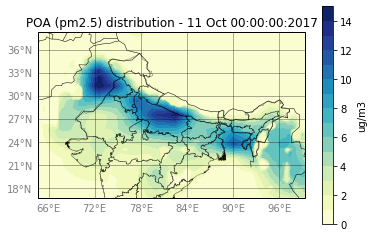

In [40]:
var_plot_2D_0(space_subset, 'oc_pm25',0,'POA (pm2.5) distribution - 11 Oct 00:00:00:2017')

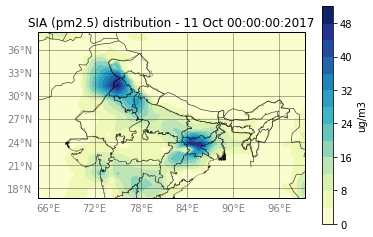

In [39]:
var_plot_2D_0(space_subset, 'tot_SIA_pm25',0,'SIA (pm2.5) distribution - 11 Oct 00:00:00:2017')

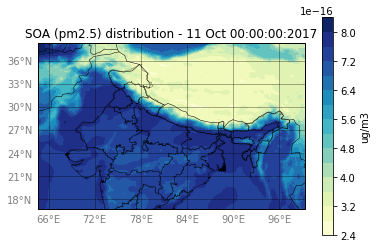

In [41]:
var_plot_2D_0(space_subset, 'pm25_soa',0,'SOA (pm2.5) distribution - 11 Oct 00:00:00:2017')

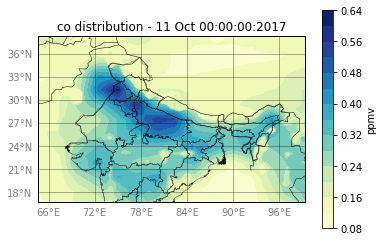

In [42]:
var_plot_2D_0(space_subset, 'co',0,'co distribution - 11 Oct 00:00:00:2017')

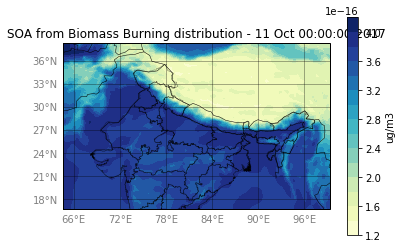

In [43]:
var_plot_2D(space_subset, 'pm25_bb_soa', 0,'SOA from Biomass Burning distribution - 11 Oct 00:00:00:2017')

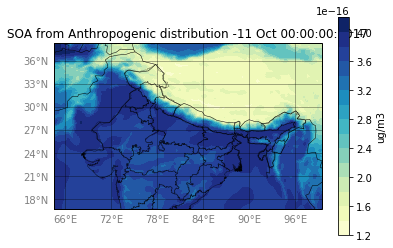

In [44]:
var_plot_2D(space_subset, 'pm25_anthro_soa', 0,'SOA from Anthropogenic distribution -11 Oct 00:00:00:2017')

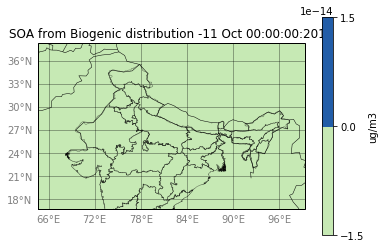

In [46]:
var_plot_2D(space_subset, 'pm25_bio_soa',0,'SOA from Biogenic distribution -11 Oct 00:00:00:2017')

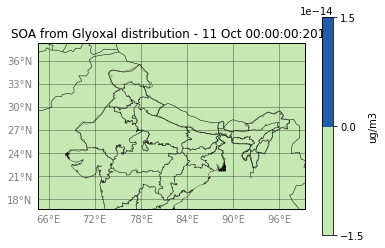

In [47]:
var_plot_2D(space_subset, 'pm25_gly_soa', 0,'SOA from Glyoxal distribution - 11 Oct 00:00:00:2017')

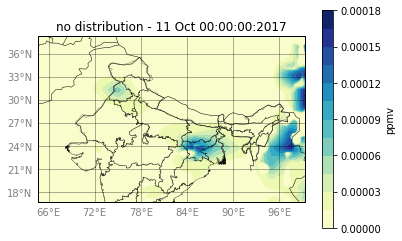

In [48]:
var_plot_2D(space_subset, 'no', 0,'no distribution - 11 Oct 00:00:00:2017')

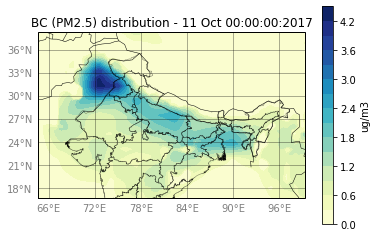

In [50]:
var_plot_2D(space_subset, 'bc_pm25', 0,'BC (PM2.5) distribution - 11 Oct 00:00:00:2017')

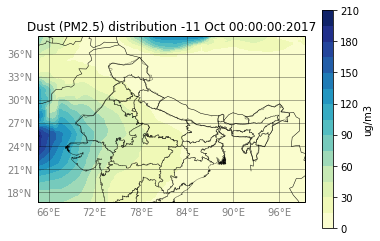

In [53]:
var_plot_2D(space_subset, 'pm25_dust',0,'Dust (PM2.5) distribution -11 Oct 00:00:00:2017')

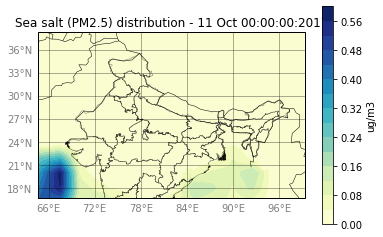

In [54]:
var_plot_2D(space_subset, 'pm25_seas', 0,'Sea salt (PM2.5) distribution - 11 Oct 00:00:00:2017')

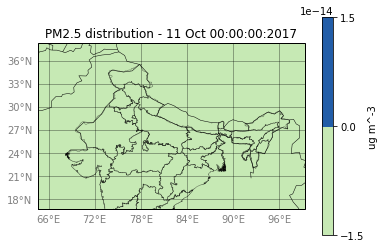

In [55]:
var_plot_2D(space_subset, 'PM2_5_DRY', 0,'PM2.5 distribution - 11 Oct 00:00:00:2017')

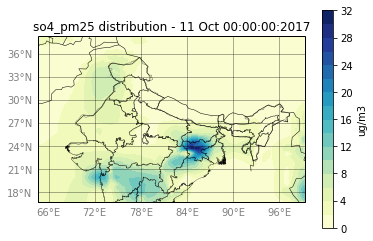

In [49]:
#LET HAVE A BETTER LOOK AT THE SIA COMPONENTS
var_plot_2D(space_subset, 'so4_pm25', 0,'so4_pm25 distribution - 11 Oct 00:00:00:2017')

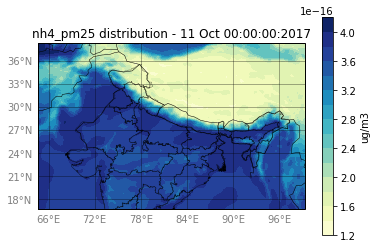

In [51]:
var_plot_2D(space_subset, 'nh4_pm25',0,'nh4_pm25 distribution - 11 Oct 00:00:00:2017')

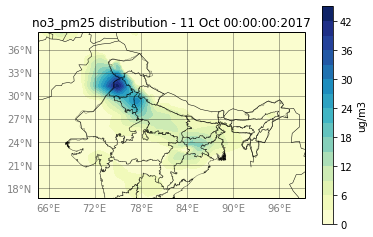

In [52]:
var_plot_2D(space_subset, 'no3_pm25',0,'no3_pm25 distribution - 11 Oct 00:00:00:2017')

# EMISSIONS

In [ ]:
#fire Emissions
fire ='/exports/csce/datastore/geos/users/s1878599/WRFchem4.0/model/WRF/test/em_real/wrffirechemi_d01_2017-10-*'
ds_fire = xr.open_mfdataset(fire, concat_dim='Time')

In [ ]:
#Adding XLAT and XLONG to dataset
datapath ='/exports/csce/datastore/geos/users/s1878599/BB_season2017_25cores_holmes/wrfout_d01_2017-10-11_00:00:00'
#Merge datasets
ds = xr.open_dataset(datapath)
#reshaping XLAT and LONG to ds_fire sizes.
lat =np.resize(ds.XLAT.values,ds_fire.ebu_in_co.shape)
long =np.resize(ds.XLONG.values,ds_fire.ebu_in_co.shape)

#adding to ds_fire
ds_fire['XLAT'] = xr.DataArray(lat, dims = ds_fire.dims)
ds_fire['XLONG'] = xr.DataArray(long, dims = ds_fire.dims)

In [ ]:
space_zoom = anly.space_subset(ds_fire,[27,35],[70,83])

In [ ]:
space_zoom

In [ ]:
timeavg_emiss = anly.var_time_mean(space_zoom)

In [ ]:
var_plot_2D(timeavg_emiss, 'ebu_in_co', 0, 'co emissions average 8-31 Oct 2017')

In [ ]:
var_plot_2D(timeavg_emiss, 'ebu_in_no', 0, 'no emissions average 8-31 Oct 2017')